Backbone to plot PETHs of PL neurons around the time of the CS for a single rat.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces
from neuropy.io.minianio import MinianIO
import session_directory as sd
from neuropy.analyses.trace_fc import load_events_from_csv


/Users/nkinsky/miniconda3/envs/NeuroPy/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Set up everything for plotting

In [2]:
def load_trace_events(sesh_dir: str, 
                      session_type: str in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 
                                            'tone_habituation', 'training'], 
                      event_type = ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline'], 
                      return_df: bool = False):
    """
    Loads events of a certain type from a session located in the specified session directory.
    
    """
    assert session_type in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 'tone_habituation', 'training']
    assert event_type in ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline']
    sesh_dir = Path(sesh_dir)
    
    session_type = 'habituation' if session_type == 'ctx_habituation' else session_type
    # Assemble csv file info into a dataframe.
    csv_files = sorted(sesh_dir.glob('**/' + session_type + '*.csv'))
    event_df_list = []
    for csv_file in csv_files:
        event_df_list.append(load_events_from_csv(csv_file))
    event_df = pd.concat(event_df_list, ignore_index=True)
    
    # Now parse events
    event_str = 'blah'
    if event_type == 'CS+':
        event_str = 'CS_end' if session_type == 'control_tone_recall' else 'CS'
        
    elif event_type == 'CS-':
        assert session_type == 'control_tone_recall', 'Can only specify "CS-" as event_type for "control_tone_recall" session_type'
        event_str = 'CS'
    
    else:
        event_str = event_type
        
    event_starts = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('start')]
    event_ends = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('end')
                         & ~event_df['Event'].str.contains('start')]
    if not return_df:
        return event_starts, event_ends
    else:
        return event_starts, event_ends, event_df
    

In [34]:
def plot_CS_PETH(sesh_dir, caneurons, session, csname, processed='C', raw='YrA', ax_all=None, label_fig=True,
                cs_color=[1, 0.647, 0, 0.3]):
    """Plot neural"""
    event_starts, event_ends = load_trace_events(str(sesh_dir), session, csname)
    nneurons = caneurons.C.shape[0]
    proc_traces = getattr(caneurons, processed)
    raw_traces = getattr(caneurons, raw) if raw is not None else [None]*nneurons
    for idc, (proc_trace, raw_trace) in enumerate(zip(proc_traces, raw_traces)):

        fig, ax, _, _, _ = plot_pe_traces(minian.times['Timestamps'], proc_trace, event_starts['Timestamp'], 
                                        event_ends=event_ends['Timestamp'], event_color=cs_color,
                                        raw_trace=raw_trace, end_buffer_sec=40, ax=ax_all[idc])
        ax = [ax] if isinstance(ax, plt.Axes) else ax
        [a.axvline(30, color='r', linestyle='--') for a in ax]
        [a.set_title(f'{csname}: Cell #{idc}') for a in ax]
        if label_fig:
            fig.suptitle(' '.join(session.capitalize().split('_')))

In [4]:
# Specify session to plot here
animal = 'Finn'
session = 'Recall1'

# Get session directory 
sesh_dir = sd.get_session_dir(animal, session)

# Load in ca imaging data from minian
minian = MinianIO(basedir=sesh_dir)

# Keep only good neurons
caneurons = minian.trim_neurons(keep="good") 


Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file


Now loop through and plot things

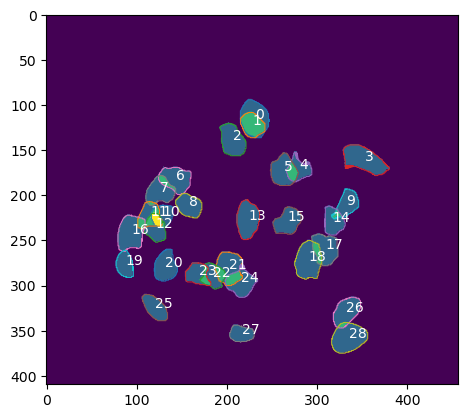

In [5]:
_, _, xe, ye = caneurons.plot_ROIs(label=True)



## Tone Recall CS+ 

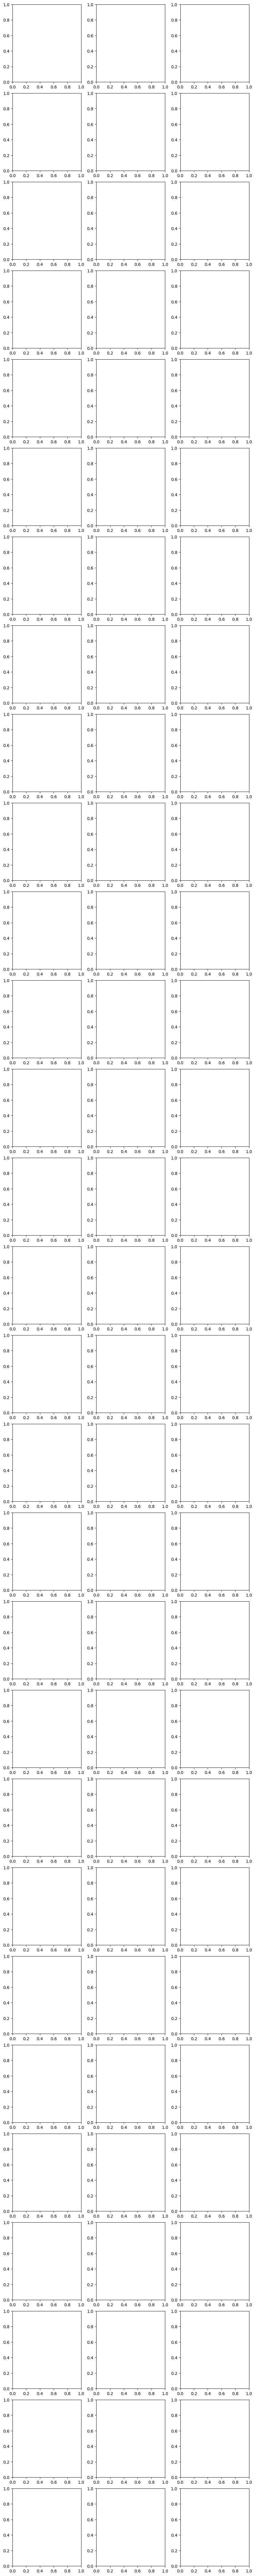

In [41]:
nneurons = caneurons.C.shape[0]
fig, ax = plt.subplots(nneurons, 3, layout='constrained', figsize=(8.5, 3*nneurons))
# fig.set_size_inches((8.5, 3*nneurons))


In [42]:
# Plot everything into appropriate place!
plot_CS_PETH(sesh_dir, caneurons, 'tone_recall', 'CS+', processed='C', raw=None, ax_all=ax[:, 0],
             cs_color=[1, 0.67, 0, 0.3])
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS-', processed='C', raw=None, ax_all=ax[:, 1],
             cs_color=[0, 1, 0, 0.3])
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS+', processed='C', raw=None, ax_all=ax[:, 2],
             cs_color=[1, 0.67, 0, 0.3])

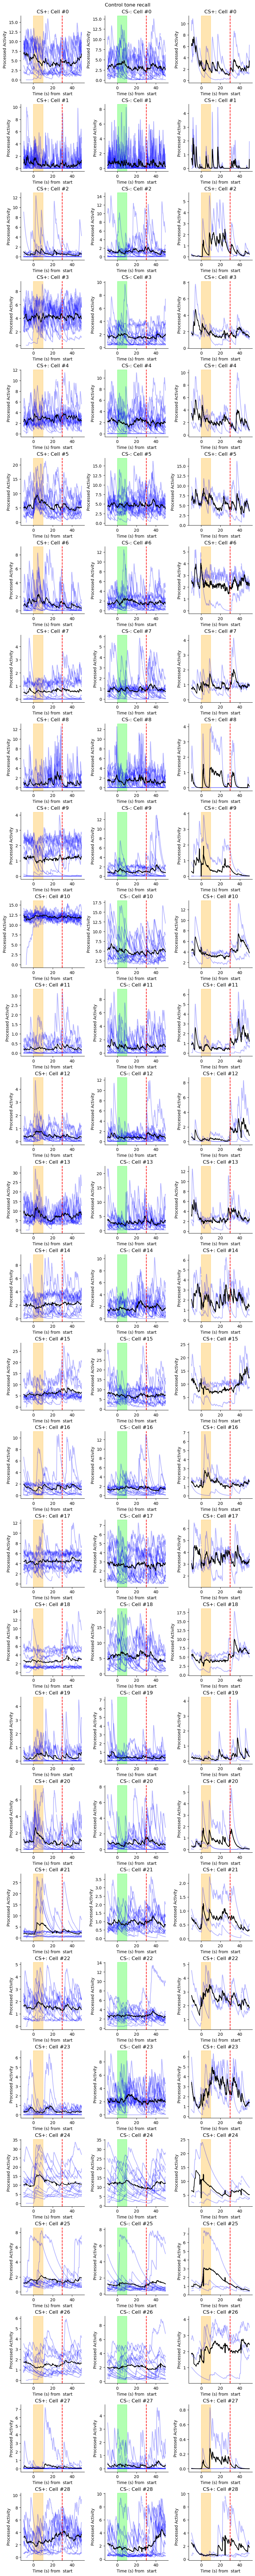

In [43]:
fig

## NRK todo:  

~~1) automate loading in events file - concatenate if there are multiple, should be easy to filter out and ignore post-hoc with pandas indexing  ~~
  
~~2) Filter out bad neurons - use "curated_neurons.pkl" file to grab only good ones~~

~~3) Debug RunTimeWarning above~~

4) turn plotting function a function on its own? Maybe keep in notebook for now and just run three separate cells? Yes.

5) Plot each neuron's activity side-by-side across all three conditions.

6) Plot across days - during training, during shock, and during recall1.

7) Fold code bits above into trace_fc class for easier access!!!
